# Task 14 - Motor Control
### Introduction to modeling and simulation of human movement
https://github.com/BMClab/bmc/blob/master/courses/ModSim2018.md


Caio Lima

* Based on task for Lecture 13 (+ Modified Joint parameters):

In [1]:
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
import math


### Muscle properties

In [2]:

Umax = .04 # SEE strain at Fmax
Lce_o = .090 #optmal l(Thellen)
Lslack = Lce_o*2.4# (Thellen)
width = .63#*Lce_o
Fmax = 1400 #maximal isometric force(Thellen)
a = 1 #inital conditional for ativation
u = 1 #Initial conditional for Brain's activation
#b = .25*10#*Lce_o 

In [3]:
### Joint Properties

In [4]:
std_foot_mass = 0.0145; #Standard foot mass
person_mass=75# mass of the person
foot_mass=person_mass*std_foot_mass #foot mass
L_foot=0.26 #lenght of the foot
Rg_prox=0.69
g = 9.81# acceleration of gravity
Rcm = 0.5*L_foot # distance knee joint to center of mass
I =foot_mass*(Rg_prox*L_foot)**2 # moment of inertia

### Initial conditions

In [5]:
phi = math.pi/2 #start as 90 degree flexion
phid = 0 #zero velocity
Lm = 0.306 #initial total lenght of the muscle
Rf=0.041 #initial RF
Lnorm_ce = .087/Lce_o #norm
t0 = 0 #Initial time
tf = 1 #Final Time
h = 1e-6 #integration step size and step counter

In [6]:
t = np.arange(t0,tf,h)
F = np.empty(t.shape)
phivec=np.empty(t.shape)
Fkpe = np.empty(t.shape)
FiberLen = np.empty(t.shape)
TendonLen = np.empty(t.shape)
a_dynamics = np.empty(t.shape)
fiberVelocity=np.empty(t.shape)

In [7]:
def TendonForce (Lnorm_see,Lslack, Lce_o):
    '''
    Compute tendon force

    Inputs:
        Lnorm_see = normalized tendon length
        Lslack = slack length of the tendon (non-normalized)
        Lce_o = optimal length of the fiber
    
    Output:
        Fnorm_tendon = normalized tendon force
        
    '''
    Umax = .04
    
    if Lnorm_see<Lslack/Lce_o: 
        Fnorm_tendon = 0
    else: 
        Fnorm_tendon = ((Lnorm_see-Lslack/Lce_o)/(Umax*Lslack/Lce_o))**2
        
    return Fnorm_tendon

In [8]:
def ParallelElementForce (Lnorm_ce):
    '''
    Compute parallel element force
    
    Inputs:
        Lnorm_ce = normalized contractile element length
    
    Output:
        Fnorm_kpe = normalized parallel element force

    '''
    Umax = 1
    
    if Lnorm_ce< 1: 
        Fnorm_kpe = 0
    else: 
        Fnorm_kpe = ((Lnorm_ce-1)/(Umax*1))**2 
        
    return Fnorm_kpe

In [9]:
def ForceLengthCurve (Lnorm_ce,width):
    F0 = max([0, (1-((Lnorm_ce-1)/width)**2)])
    return F0

In [10]:
def ContractileElementDot(F0, Fnorm_CE, a):
    
    '''
    Compute Contractile Element Derivative

    Inputs:
        F0 = Force-Length Curve
        Fce = Contractile element force
    
    Output:
        Lnorm_cedot = normalized contractile element length derivative

    '''
    
    FMlen = 1.4 # young adults
    Vmax = 10  # young adults
    Af = 0.25  #force-velocity shape factor
    
    Fnorm_CE = min(FMlen*a*F0 - 0.001, Fnorm_CE)
    
    if  Fnorm_CE > a*F0:
        
        b = ((2 + 2/Af)*(a*F0*FMlen - Fnorm_CE))/(FMlen-1)
        
    elif Fnorm_CE <= a*F0:
        
        b = a*F0 + Fnorm_CE/Af
    
    Lnorm_cedot = (.25 + .75*a)*Vmax*((Fnorm_CE - a*F0)/b)
    
    return Lnorm_cedot

In [11]:
def ContractileElementForce(Fnorm_tendon,Fnorm_kpe, alpha):
    '''
    Compute Contractile Element force

    Inputs:
        Fnorm_tendon = normalized tendon force
        Fnorm_kpe = normalized parallel element force
    
    Output:
        Fnorm_CE = normalized contractile element force
    '''
    Fnorm_CE = Fnorm_tendon/np.cos(alpha) - Fnorm_kpe
    return Fnorm_CE

In [12]:
def tendonLength(Lm,Lce_o,Lnorm_ce, alpha):
    '''
    Compute tendon length
    
    Inputs:
        Lm = 
        Lce_o = optimal length of the fiber
        Lnorm_ce = normalized contractile element length
    
    Output:
        Lnorm_see = normalized tendon length   
    '''
    Lnorm_see = Lm/Lce_o - Lnorm_ce*np.cos(alpha)
    
    return Lnorm_see

In [13]:
def activation(a,u,dt):
    '''
    Compute activation
    
    Inputs:
        u = idealized muscle excitation signal, 0 <= u <= 1
        a = muscular activation
        dt = time step
    
    Output:
        a = muscular activation  
    '''
    
    tau_deact = 50e-3 #young adults
    tau_act = 15e-3
    
    if u>a:
        tau_a = tau_act*(0.5+1.5*a)
    elif u <=a:
        tau_a = tau_deact/(0.5+1.5*a)
    
    #-------
    dadt = (u-a)/tau_a # euler
    
    a = a + dadt*dt
    #-------
    return a

In [14]:
def ComputeTotalLenghtSize(phi):
    '''
    Inputs:
        phi = degree flexion of the joint
    Output:
        Lm = total muscle lenght
    '''
    A0=30.60/100
    A1=((-7.44e-2*180)/math.pi)/100
    A2=((-1.41e-4*180)/math.pi)/100
    A3=((2.42e-6*180)/math.pi)/100
    A4=((1.5e-8*180)/math.pi)/100
    Lm =A0*phi**0+A1*phi**1+A2*phi**2+A3*phi**3+A4*phi**4
    return Lm

In [15]:
def ComputeRf(phi):
    '''
    Inputs:
        phi = degree flexion of the joint
    Output:
        Rf = moment arm
    '''
    B0=4.30/100
    B1=((1.66e-2*180)/math.pi)/100
    B2=((-3.89e-4*180)/math.pi)/100
    B3=((-4.45e-6*180)/math.pi)/100
    B4=((-4.34e-8*180)/math.pi)/100
    
    Lm =B0*phi**0+B1*phi**1+B2*phi**2+B3*phi**3+B4*phi**4
    return Rf

In [16]:
def ComputeMomentJoint(Rf,Fnorm_tendon,Fmax,Rcm,foot_mass,g,phi):
    '''
    Inputs:
        RF = Moment arm
        Fnorm_tendon = Normalized tendon force
        foot_mass = mass of the foot
        Rcm- distance of the center mass the board
        g = Acelleration of gravity
        Fmax= maximal isometric force
    Output:
        M = Total moment with respect to joint
    '''
    M=Rf*Fnorm_tendon*Fmax - foot_mass*g*Rcm*np.sin((math.pi/2)-phi)
    return M

In [17]:
def ComputeAngularAcelerationJoint (M,I):
    '''
    Inputs:
        M = Total moment with respect to joint
        I = Moment of Inertia
    Output:
        phidd= angular aceleration of the joint
    '''
    phidd = M/I
    return phidd

## Simulation - Parallel

In [18]:
#Normalizing
alpha = 7*np.pi/180 #defined as 7° the alpha angle

for i in range (len(t)):
     
    Rf= ComputeRf(phi)
        
    Lm =  ComputeTotalLenghtSize(phi)
    
    Lnorm_see = tendonLength(Lm,Lce_o,Lnorm_ce, alpha)

    Fnorm_tendon = TendonForce(Lnorm_see,Lslack, Lce_o) 
    
    Fnorm_kpe = ParallelElementForce(Lnorm_ce)     
        
    #isometric force at Lce from CE force length relationship
    F0 = ForceLengthCurve (Lnorm_ce,width)
    
    Fnorm_CE = ContractileElementForce(Fnorm_tendon,Fnorm_kpe, alpha) #Fnorm_CE = ~Fm
    
    #computing activation
    a = activation(a,u,h)
    
    #calculate CE velocity from Hill's equation    
    Lnorm_cedot = ContractileElementDot(F0, Fnorm_CE,a)
    
    #Compute MomentJoint
    M = ComputeMomentJoint(Rf,Fnorm_tendon,Fmax,Rcm,foot_mass,g,phi)
    
    #Compute Angular Aceleration Joint
    phidd = ComputeAngularAcelerationJoint (M,I)
    
    # Euler integration steps
    Lnorm_ce = Lnorm_ce + h*Lnorm_cedot
    phid= phid + h*phidd
    phi  = phi  +h*phid
    phideg= (phi*180)/math.pi #convert joint angle from radians to degree


    # Store variables in vectors
    F[i] = Fnorm_tendon*Fmax
    Fkpe[i] = Fnorm_kpe*Fmax
    FiberLen[i] = Lnorm_ce*Lce_o
    TendonLen[i] = Lnorm_see*Lce_o
    a_dynamics[i] = a
    phivec[i] = phideg
    fiberVelocity[i]=Lnorm_cedot*Lce_o

## Plots 

<IPython.core.display.Javascript object>


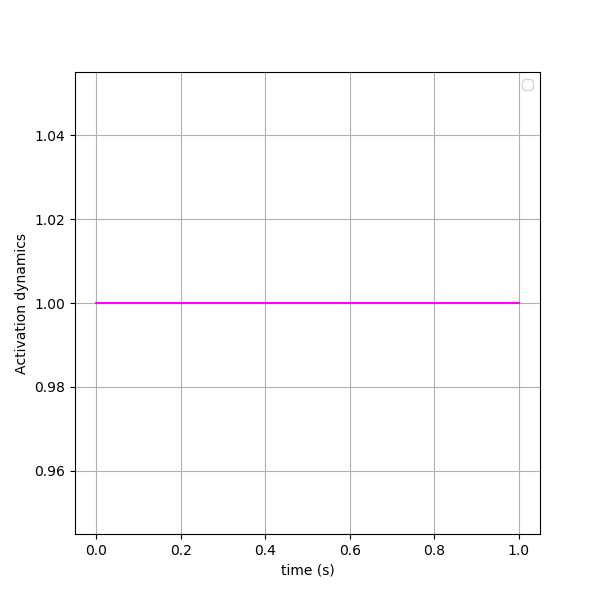

No handles with labels found to put in legend.


In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,a_dynamics,c='magenta')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Activation dynamics')


ax.legend()

<IPython.core.display.Javascript object>


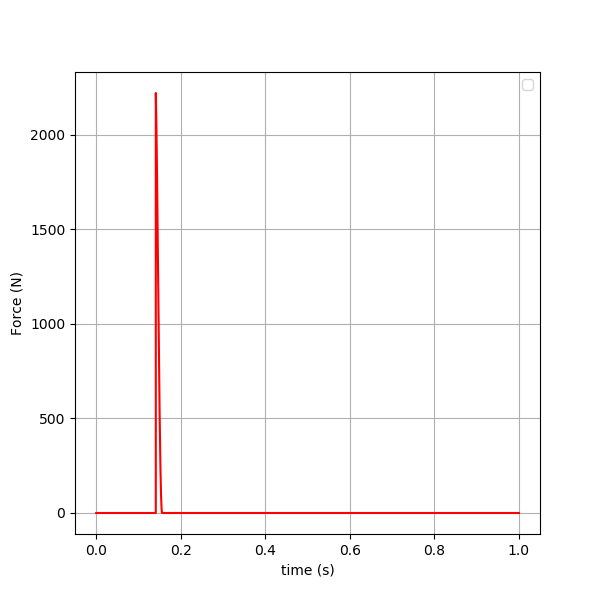

No handles with labels found to put in legend.


In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,F,c='red')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Force (N)')


ax.legend()

<IPython.core.display.Javascript object>


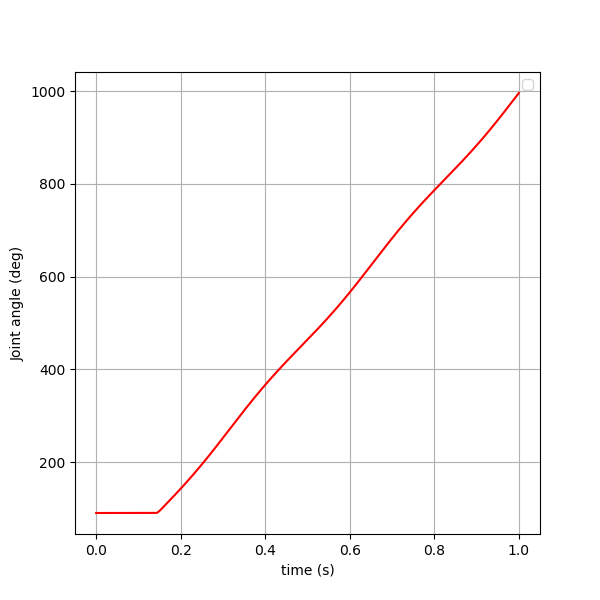

No handles with labels found to put in legend.


In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,phivec,c='red')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Joint angle (deg)')


ax.legend()

<IPython.core.display.Javascript object>


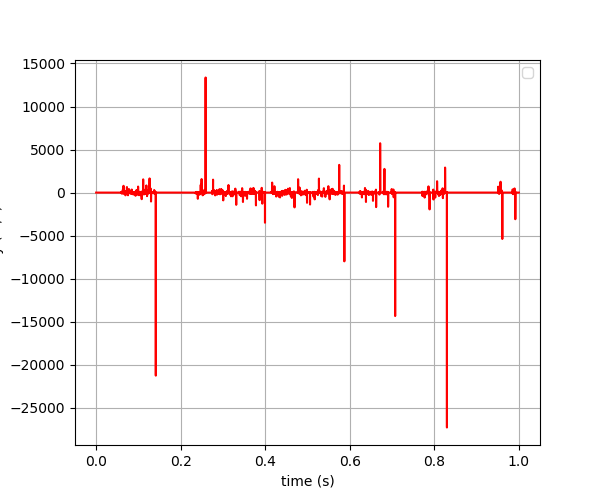

No handles with labels found to put in legend.


In [22]:
fig, ax = plt.subplots(1, 1, figsize=(6,5), sharex=True)

ax.plot(t,fiberVelocity,c='red')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Velocity (m/s)')


ax.legend()

<IPython.core.display.Javascript object>


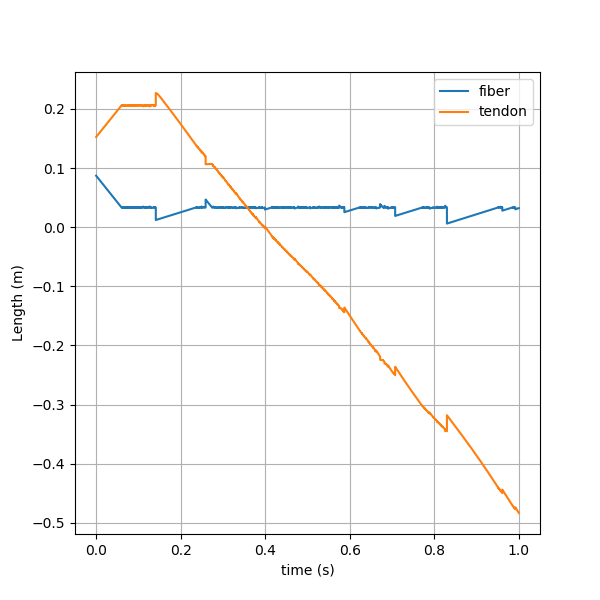

<IPython.core.display.Javascript object>


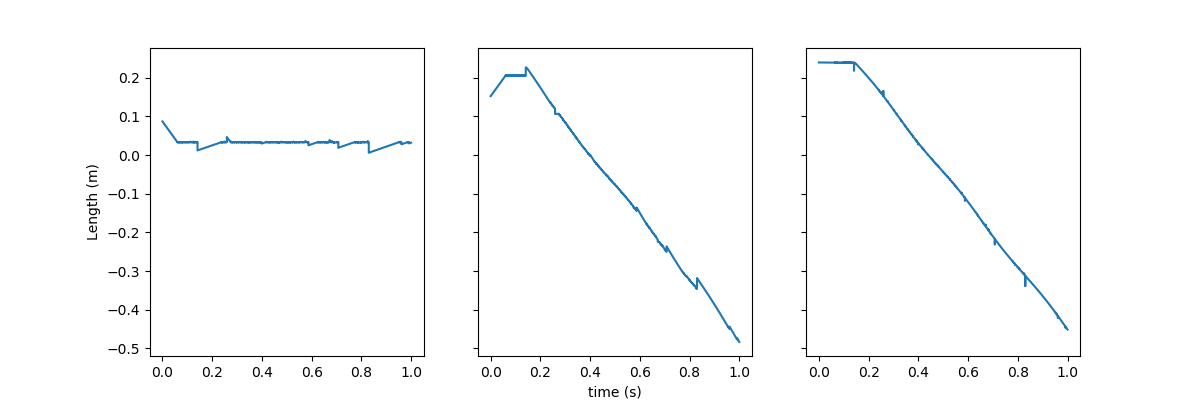

Text(0,0.5,'Length (m)')

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,FiberLen, label = 'fiber')
ax.plot(t,TendonLen, label = 'tendon')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Length (m)')
ax.legend(loc='best')


fig, ax = plt.subplots(1, 3, figsize=(12,4), sharex=True, sharey=True)
ax[0].plot(t,FiberLen, label = 'fiber')
ax[1].plot(t,TendonLen, label = 'tendon')
ax[2].plot(t,FiberLen + TendonLen, label = 'muscle (tendon + fiber)')

ax[1].set_xlabel('time (s)')
ax[0].set_ylabel('Length (m)')
#plt.legend(loc='best')